# Portfolio diversification with varying investor abilities

N. James and M. Menzies

[Link to paper](https://arxiv.org/pdf/2311.06519.pdf)

## Inspirations

 * We acknowledge portfolio optimisation as a difficult procedure, especially over non-convex sets.
 * We consider a growing body of work that it is frequently difficult to beat equally weighted portfolios.
 * We address the idea of “investor skill,” where we study the optimal cardinality of portfolios for investors with varying levels of success in picking “winning” securities.

> "We specifically investigate two aspects of portfolio selection: what the distribution of portfolio outcomes looks like across different cardinalities k and different levels of investor skill."

## Optimization Assumptions

 * Risk free rate: $R_f = 0$
 * **Sharpe-optimal weights**: $\max \left( \frac{r_{\pi} - r_f}{\sigma_{\pi}} \right) $
 * Each year contains the same period of trading days: $P = 252$

## Constraints
 * **Budget constraint**: Requires the whole capital to be invested: $\sum_{i=1}^k w_i = 1$
 * **Positive weights**: Investments to each asset is non negative: $0 \leq w_i \leq 1, i = 1,...,k$
 * **Quantity constraint**: The quantity constraint specifies a lower ($\epsilon$) and upper ($\delta$) bounds allowed for the allocated proportions to each asset in a portfolio.


## Data

The authors use 370 US equities from S&P500 with at least 20 years of history, and separate each dataset into one-year periods. We will use 309 S&P500 equities with the same history length.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tqdm
import yfinance as yf

from numpy.typing import NDArray
from scipy.optimize import minimize

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
sns.set_theme()

In [8]:
equity_data = pd.read_csv("./files/equity.csv", index_col=0)
equity_data.head()

,A,AA,AAPL,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMB,WMT,WY,X,XEL,XOM,XRAY,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,43.757736,70.691589,0.847207,9.081110,16.274670,28.572292,6.473895,24.924671,8.052908,10.770648,...,9.498190,43.555931,11.621569,23.991533,7.112461,18.499037,6.695474,36.800503,4.703721,36.146141
2000-01-04,40.415142,71.019104,0.775779,8.821651,14.909401,27.126852,6.406455,24.924671,7.660816,10.770648,...,9.287542,41.926174,11.184974,23.095974,7.276233,18.144711,6.695474,35.088840,4.609175,34.395828
2000-01-05,37.908195,75.113220,0.787131,8.805430,15.204175,27.522856,6.305304,24.685013,7.178246,11.187303,...,9.862027,41.070515,11.777483,23.331652,7.556982,19.133884,6.811221,36.895588,4.632809,34.355137
2000-01-06,36.464787,74.130623,0.719014,9.113539,15.328292,26.770428,6.339020,25.014551,6.740914,11.145638,...,10.072677,41.518700,12.328423,23.473057,7.486801,20.123055,6.820127,36.134842,4.593416,34.843594
2000-01-07,39.503517,73.912254,0.753073,9.210842,16.072979,27.522856,6.440175,25.583738,7.540173,11.312298,...,10.340772,44.656055,11.923018,24.085800,7.486801,20.063992,6.802317,36.990673,4.490990,34.924999


In [9]:
yearly_data = {}

for year in range(2001, 2024):
    idx = (f'{year - 1}-01-01' <= equity_data.index) & (equity_data.index < f'{year}-01-01')
    yearly_data[f"{year - 1}"] = equity_data[idx]

In [10]:
equity_names = list(equity_data.columns.values)
P = 252
Rf = 0
K = range(10, 101)
sample_portfolios = 1000

In [11]:
def opt_sharpe(rets: pd.DataFrame, n: int):

    def neg_sharpe(weights: NDArray):
        mean = rets.values.dot(weights).mean() * 252
        sigma = (weights.dot(rets.cov().values).dot(weights)) ** 0.5 * (252 ** 0.5)
        return -(mean / sigma)
    
    w0 = np.ones(n) / n

    # Quantity constraint
    eps = 1 / (2*n)
    delta = 1
    bnds = ((eps, delta),) * n

    # Budget constraint
    cons = ({
        "type": "eq",
        "fun": lambda w: np.sum(w) - 1
    },)

    res = minimize(fun=neg_sharpe, x0=w0, bounds=bnds, constraints=cons, tol=1e-8)
    opt_weights = res.x

    return opt_weights, -neg_sharpe(opt_weights)
    
    

<h2>Warning: This takes around 4 d</h2>

In [14]:
yearly_10_percs = {}
yearly_50_percs = {}
yearly_90_percs = {}

for y in range(2000, 2023):
    ydata = yearly_data[f"{y}"]
    perc_10_sr = []
    perc_50_sr = []
    perc_90_sr = []
    for k in tqdm.tqdm(K):
        portfolios = [list(np.random.choice(equity_names, size=k, replace=False)) for _ in range(sample_portfolios)]
        sharpe_ratios = []
        for portfolio in portfolios:
            portfolio_rets = ydata.loc[:, portfolio].pct_change().dropna()
            weights, sharpe = opt_sharpe(portfolio_rets, k)
            sharpe_ratios.append(sharpe)
        perc_10_sr.append(np.percentile(sharpe_ratios, 10))
        perc_50_sr.append(np.percentile(sharpe_ratios, 50))
        perc_90_sr.append(np.percentile(sharpe_ratios, 90))
    yearly_10_percs[f"{y}"] = perc_10_sr
    yearly_50_percs[f"{y}"] = perc_50_sr
    yearly_90_percs[f"{y}"] = perc_90_sr
    print(f"Finished year {y}.")

100%|████████████████████████████████████████| 91/91 [6:42:48<00:00, 265.58s/it]


Finished year 2000.


100%|████████████████████████████████████████| 91/91 [5:03:53<00:00, 200.37s/it]


Finished year 2001.


100%|████████████████████████████████████████| 91/91 [2:32:22<00:00, 100.47s/it]


Finished year 2002.


100%|████████████████████████████████████████| 91/91 [5:35:07<00:00, 220.96s/it]


Finished year 2003.


100%|████████████████████████████████████████| 91/91 [5:17:31<00:00, 209.36s/it]


Finished year 2004.


100%|████████████████████████████████████████| 91/91 [4:55:55<00:00, 195.12s/it]


Finished year 2005.


100%|████████████████████████████████████████| 91/91 [5:06:40<00:00, 202.20s/it]


Finished year 2006.


100%|████████████████████████████████████████| 91/91 [3:14:40<00:00, 128.36s/it]


Finished year 2007.


100%|█████████████████████████████████████████| 91/91 [1:45:39<00:00, 69.67s/it]


Finished year 2008.


100%|████████████████████████████████████████| 91/91 [3:09:54<00:00, 125.21s/it]


Finished year 2009.


100%|████████████████████████████████████████| 91/91 [3:01:27<00:00, 119.64s/it]


Finished year 2010.


100%|████████████████████████████████████████| 91/91 [2:38:26<00:00, 104.46s/it]


Finished year 2011.


100%|████████████████████████████████████████| 91/91 [3:54:01<00:00, 154.31s/it]


Finished year 2012.


100%|████████████████████████████████████████| 91/91 [4:45:10<00:00, 188.02s/it]


Finished year 2013.


100%|████████████████████████████████████████| 91/91 [3:59:58<00:00, 158.22s/it]


Finished year 2014.


100%|█████████████████████████████████████████| 91/91 [2:23:26<00:00, 94.57s/it]


Finished year 2015.


100%|████████████████████████████████████████| 91/91 [4:54:22<00:00, 194.10s/it]


Finished year 2016.


100%|████████████████████████████████████████| 91/91 [6:21:09<00:00, 251.31s/it]


Finished year 2017.


100%|████████████████████████████████████████| 91/91 [3:06:54<00:00, 123.24s/it]


Finished year 2018.


100%|████████████████████████████████████████| 91/91 [5:08:23<00:00, 203.34s/it]


Finished year 2019.


100%|████████████████████████████████████████| 91/91 [3:22:47<00:00, 133.71s/it]


Finished year 2020.


100%|████████████████████████████████████████| 91/91 [5:18:39<00:00, 210.11s/it]


Finished year 2021.


100%|████████████████████████████████████████| 91/91 [3:29:07<00:00, 137.89s/it]

Finished year 2022.


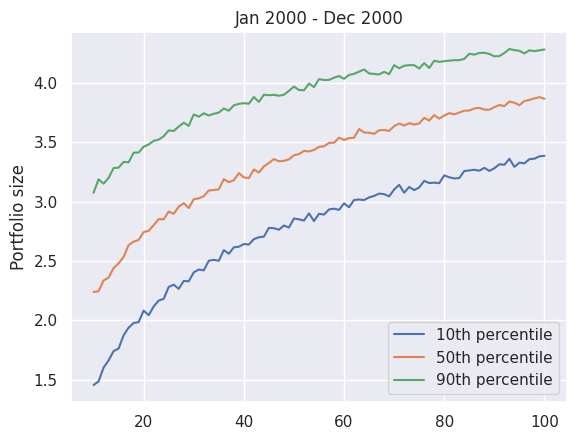

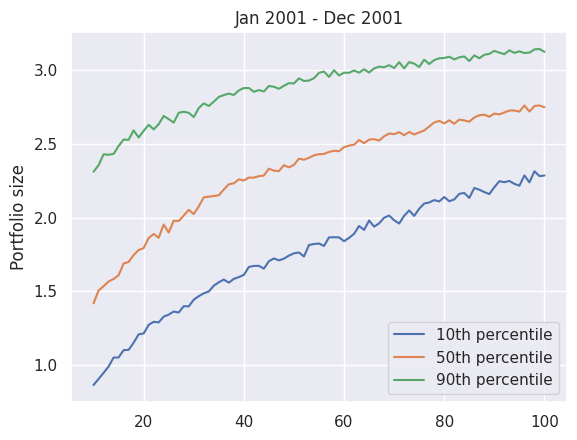

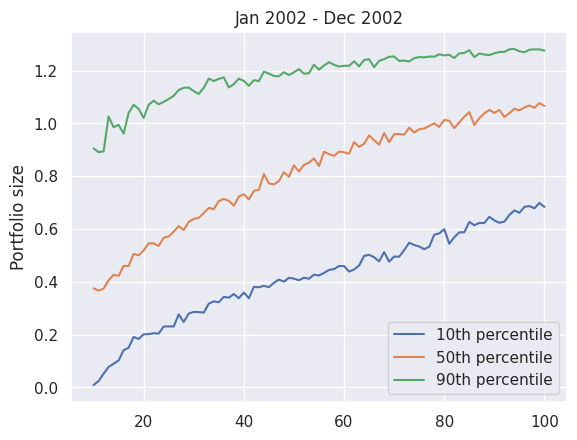

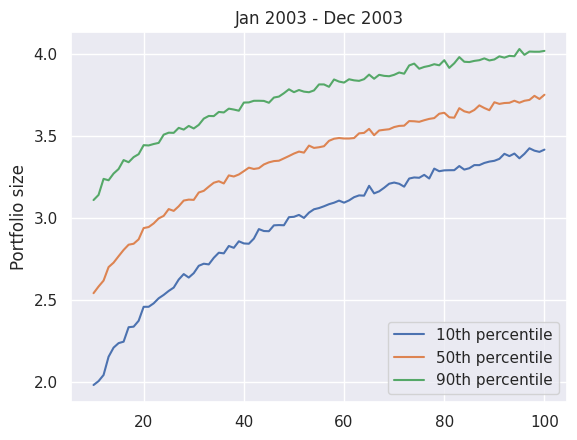

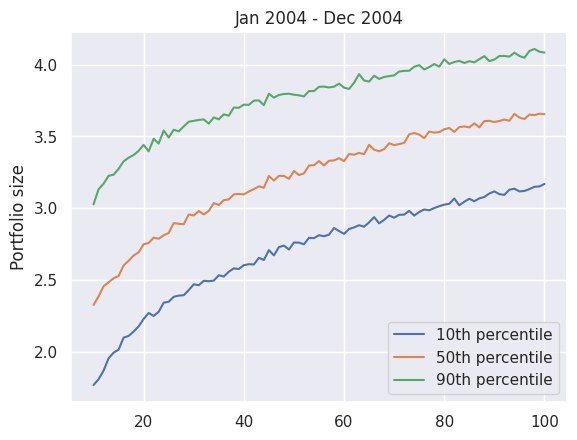

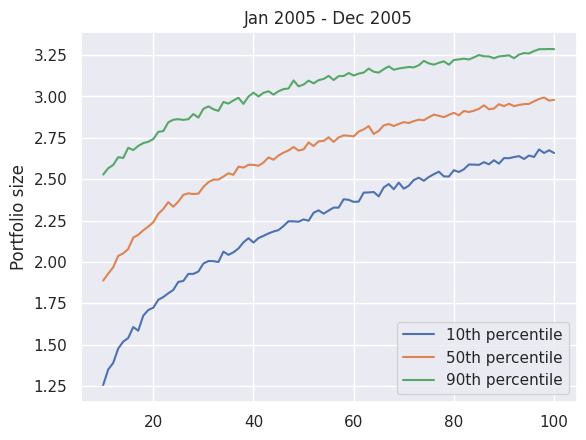

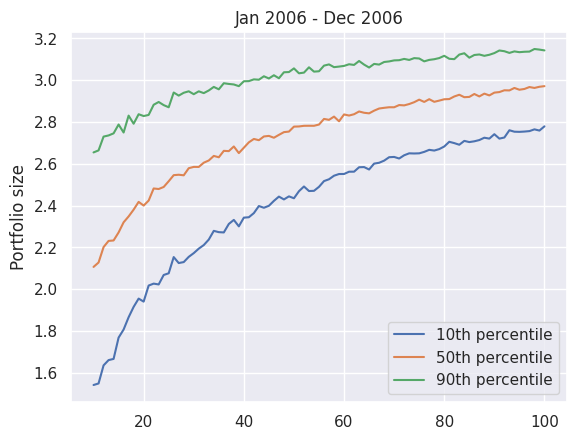

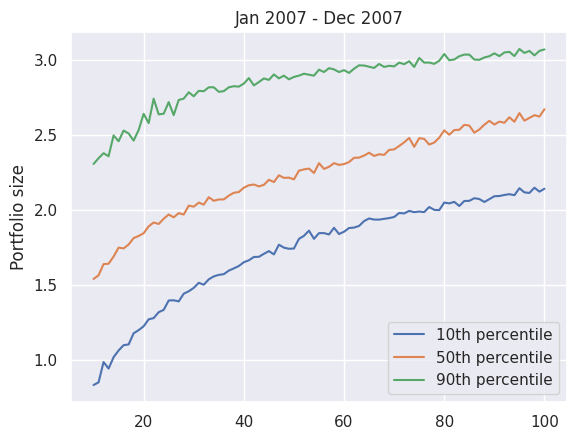

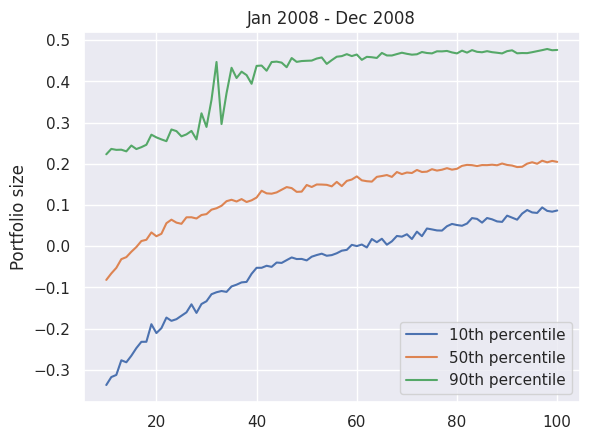

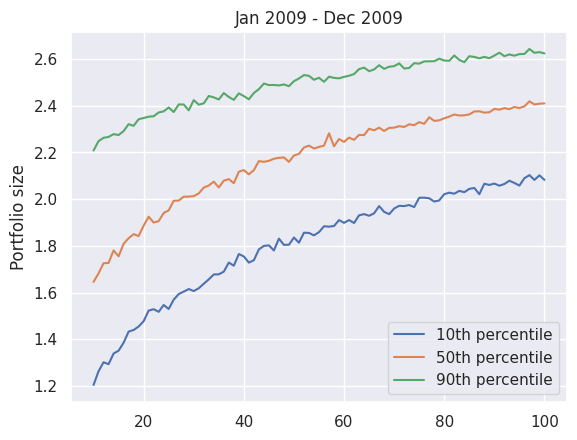

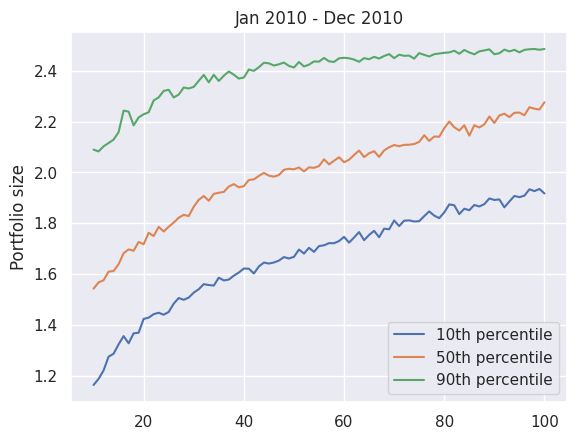

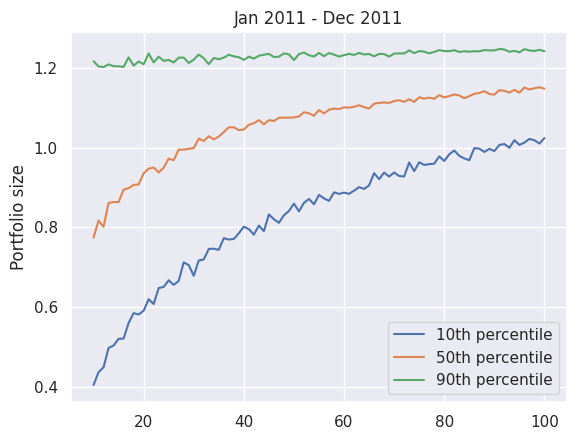

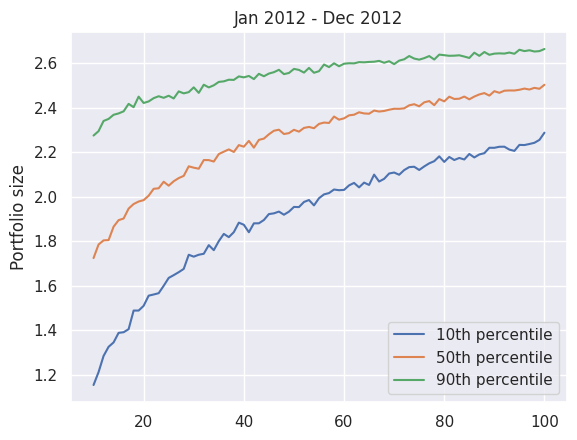

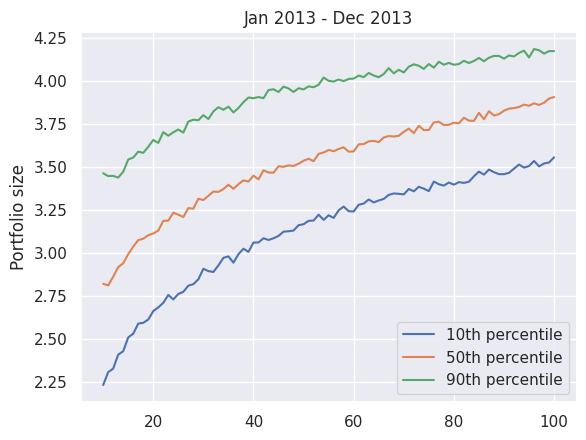

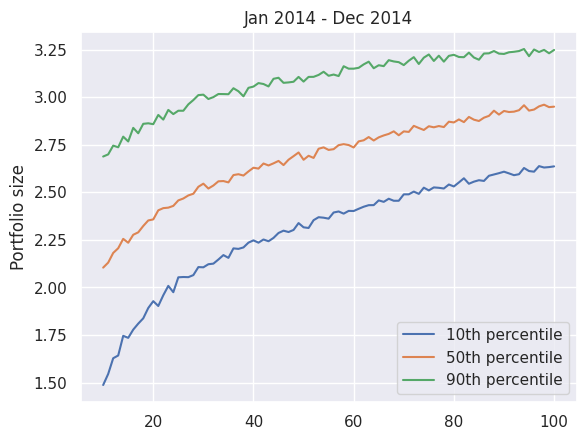

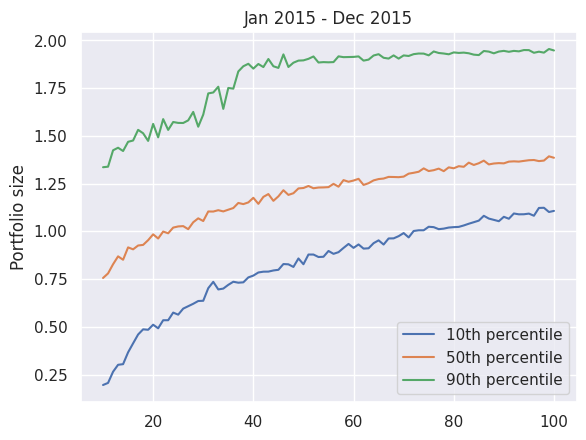

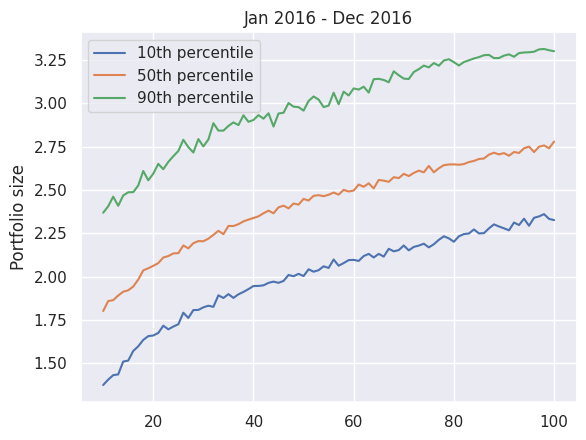

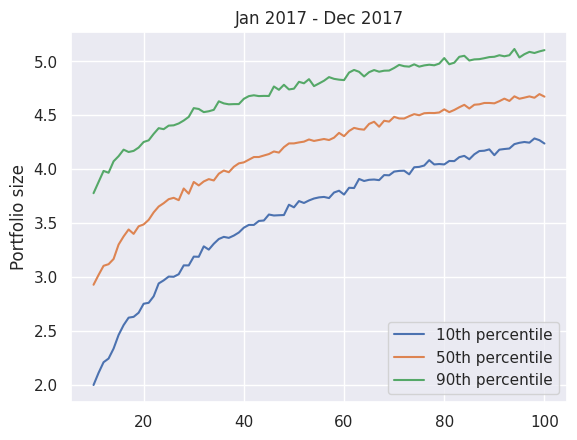

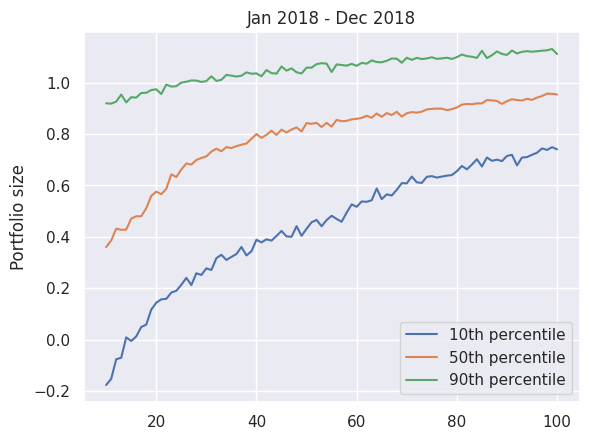

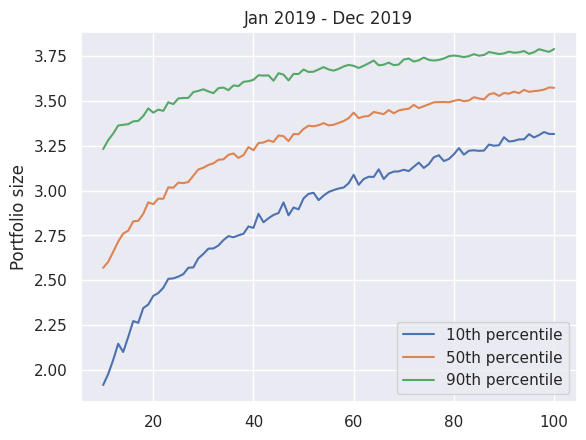

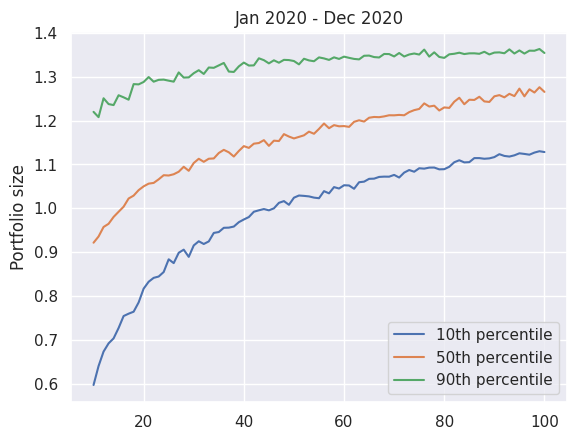

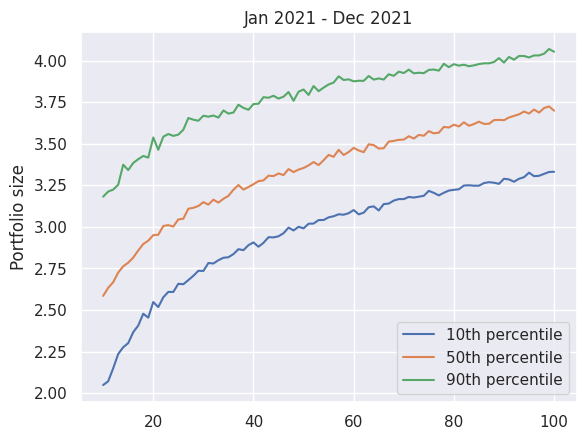

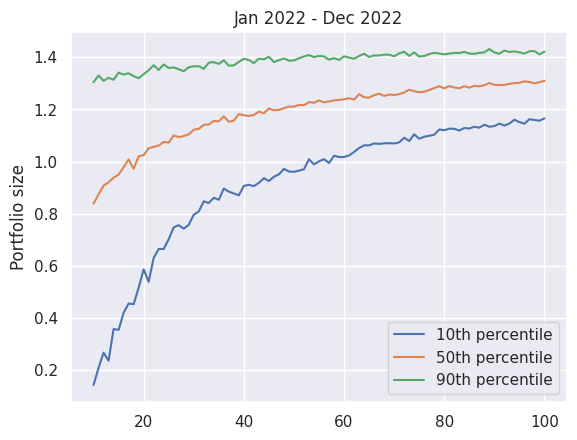

In [15]:
for y in range(2000, 2023):
    plt.title(f"Jan {y} - Dec {y}")
    plt.plot(K, yearly_10_percs[f"{y}"], label="10th percentile")
    plt.plot(K, yearly_50_percs[f"{y}"], label="50th percentile")
    plt.plot(K, yearly_90_percs[f"{y}"], label="90th percentile")
    plt.legend()
    plt.ylabel("Sharpe ratio")
    plt.ylabel("Portfolio size")
    plt.show()

In [16]:
yearly_10_percs

{'2000': [1.4543224950202303,
  1.4841696572452932,
  1.6005999976170986,
  1.661763140696952,
  1.73975663842874,
  1.7616954528858508,
  1.8736331683213028,
  1.9375263891016867,
  1.9768733587230245,
  1.9846589363131757,
  2.0816864419472587,
  2.0426129531675397,
  2.1160534198352274,
  2.165797833556435,
  2.180121976610723,
  2.280253948254961,
  2.299996254265616,
  2.264974118513777,
  2.330941833514701,
  2.3281958340837194,
  2.4034917240037017,
  2.427815433988264,
  2.4206270607388807,
  2.501631457190058,
  2.5089666713259255,
  2.5011518306800276,
  2.5906617879270772,
  2.5605306879481917,
  2.6148379944232008,
  2.619560285140017,
  2.6425825343354803,
  2.637823423718083,
  2.683567597476244,
  2.6993851996129288,
  2.7047939664164407,
  2.778444545077472,
  2.776033171695364,
  2.763078901681302,
  2.7984512391160767,
  2.7811403045833467,
  2.8578269645520957,
  2.850512432955196,
  2.8405186994820966,
  2.9005043727011772,
  2.835531026853874,
  2.897607668288131,


In [17]:
# sharpes = {
#     "10p": yearly_10_percs,
#     "50p": yearly_50_percs,
#     "90p": yearly_90_percs
# }

In [21]:
# with open('./files/opt_sharpes.pkl', 'wb') as f:
#     pickle.dump(sharpes, f)